# beta-Bernoulli
1. conjugate model -> closed-form solution
3. optimize() to get MAT/MLE
2. mcmc by stan
3. compare the density from the conjugate pair  and density plot from MCMC

- Bernoulli experiment: $ Y = \{1, 1, 1, 0\} $
- Prior model: $\theta \sim \mathrm{Beta}(3,4)$
- Posterior (conjugate): $p(\theta \mid Y) = \mathrm{Beta}(\theta \mid 6, 5)$

In [ ]:
# Imports and helpers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from math import gamma

sns.set(style="whitegrid", context="notebook")

# Data and prior
Y = np.array([1, 1, 1, 0], dtype=int)
N = len(Y)
s = int(Y.sum())
alpha0, beta0 = 3, 4  # prior Beta(3,4)

# Conjugate posterior parameters
alpha_post = alpha0 + s            # 3 + 3 = 6
beta_post = beta0 + (N - s)        # 4 + 1 = 5

# Basic summaries
post_mean = alpha_post / (alpha_post + beta_post)
post_map = ((alpha_post - 1) / (alpha_post + beta_post - 2)) if alpha_post > 1 and beta_post > 1 else np.nan

print({
    "N": N,
    "sum_success": s,
    "prior": (alpha0, beta0),
    "posterior": (alpha_post, beta_post),
    "post_mean": post_mean,
    "post_map": post_map,
})

{'N': 4, 'sum_success': 3, 'prior': (3, 4), 'posterior': (6, 5), 'post_mean': 0.5454545454545454, 'post_map': 0.5555555555555556}


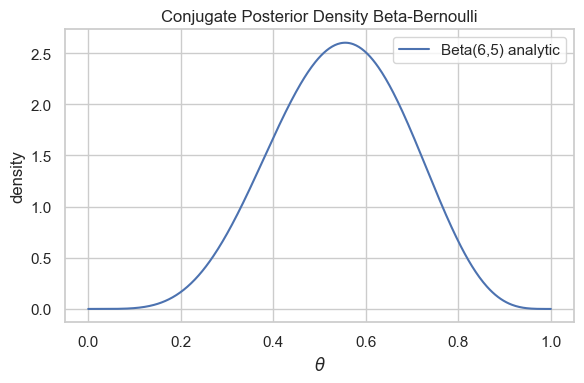

In [12]:
# Simple Beta PDF without SciPy

def beta_pdf(x, a, b):
    x = np.asarray(x, dtype=float)
    coef = gamma(a + b) / (gamma(a) * gamma(b))
    y = coef * np.power(x, a - 1) * np.power(1 - x, b - 1)
    y[(x <= 0) | (x >= 1)] = 0.0
    return y

# Plot the conjugate posterior density
xs = np.linspace(0, 1, 500)
ys = beta_pdf(xs, alpha_post, beta_post)
plt.figure(figsize=(6,4))
plt.plot(xs, ys, label=f"Beta({alpha_post},{beta_post}) analytic")
plt.title("Conjugate Posterior Density Beta-Bernoulli")
plt.xlabel(r"$\theta$")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()

## Sample with cmdstanpy

We compile and sample using cmdstanpy. If CmdStan is not installed, uncomment the install step.


In [2]:
#  !pip install cmdstanpy
# import cmdstanpy
# cmdstanpy.install_cmdstan(compiler=True)  # Uncomment this line if CmdStan is not installed

In [3]:
import os
print("CMDSTAN path:", os.environ.get("CMDSTAN"))

print("PATH entries containing 'RTools':") # Check for RTools in PATH, Windows specific
path_list = os.environ.get("PATH", "").split(os.pathsep)
for p in path_list:
    if "RT" in p:
        print(p)


CMDSTAN path: C:\Users\yongd\.cmdstan\cmdstan-2.37.0
PATH entries containing 'RTools':
C:\Users\yongd\.cmdstan\RTools40
C:\Users\yongd\.cmdstan\RTools40\mingw64\bin
C:\Users\yongd\.cmdstan\RTools40
C:\Users\yongd\.cmdstan\RTools40\mingw64\bin


## Stan model: Beta-Bernoulli with posterior predictive

We implement a simple Bernoulli likelihood with $\theta \sim \mathrm{Beta}(3,4)$ and generate posterior predictive samples.


In [4]:
# Write Stan model to file
stan_code = r"""
// beta_bernoulli.stan

functions {
  // none needed
}

data {
  int<lower=0> N;                 // number of trials
  array[N] int<lower=0, upper=1> y;     // outcomes
  real<lower=0> alpha0;           // prior alpha
  real<lower=0> beta0;            // prior beta
}

parameters {
  real<lower=0, upper=1> theta;   // success probability
}

model {
  theta ~ beta(alpha0, beta0);    // prior
  y ~ bernoulli(theta);            // likelihood
}

generated quantities {
  array[N] int<lower=0, upper=1> y_rep; // replicated data
  vector[N] log_lik;
  for (n in 1:N) {
    y_rep[n] = bernoulli_rng(theta);
    log_lik[n] = bernoulli_lpmf(y[n] | theta);
  }
}
"""

stan_path = Path("beta_bernoulli.stan")
stan_path.write_text(stan_code)
print(f"Wrote Stan model to {stan_path.resolve()}")

Wrote Stan model to C:\Users\yongd\Documents\git\KOS6002\beta_bernoulli.stan


## Sample with cmdstanpy

We compile and sample using cmdstanpy. If CmdStan is not installed, uncomment the install step.


In [5]:
# Compile and sample
import importlib

has_cmdstanpy = importlib.util.find_spec("cmdstanpy") is not None
print("cmdstanpy available:", has_cmdstanpy)

draws_theta = None
y_rep = None

if has_cmdstanpy:
    try:
        from cmdstanpy import CmdStanModel, cmdstan_path, install_cmdstan
        # If you need to install CmdStan (first time), uncomment the following line.
        # install_cmdstan()

        model = CmdStanModel(stan_file=str(stan_path))

        data = {
            "N": int(N),
            "y": Y.astype(int).tolist(),
            "alpha0": float(alpha0),
            "beta0": float(beta0),
        }

        fit = model.sample(data=data, chains=4, seed=123, iter_sampling=1000, iter_warmup=500)
        # print(fit)

        # Extract draws
        draws_theta = fit.stan_variable("theta")  # shape (draws,)
        y_rep = fit.stan_variable("y_rep")        # shape (draws, N)
    except Exception as e:
        print("Skipping MCMC due to error during compile/run:")
        print(e)
else:
    print("cmdstanpy not found. You can still use the conjugate analysis cells above.")

cmdstanpy available: True


C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
00:05:59 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\KOS6002\beta_bernoulli.stan to exe file C:\Users\yongd\Documents\git\KOS6002\beta_bernoulli.exe
00:05:59 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\KOS6002\beta_bernoulli.stan to exe file C:\Users\yongd\Documents\git\KOS6002\beta_bernoulli.exe
00:06:07 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\KOS6002\beta_bernoulli.exe
00:06:07 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\KOS6002\beta_bernoulli.exe
00:06:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:0


00:06:07 - cmdstanpy - INFO - CmdStan done processing.


## Compare MCMC posterior vs analytic Beta(6,5)

Overlay MCMC samples of $\theta$ with the analytic conjugate posterior density.


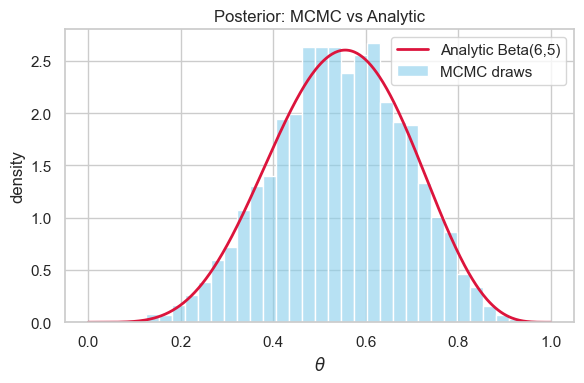

In [6]:
# Overlay MCMC draws and analytic curve
if draws_theta is not None:
    xs = np.linspace(0, 1, 500)
    ys = beta_pdf(xs, alpha_post, beta_post)

    plt.figure(figsize=(6,4))
    sns.histplot(draws_theta, stat="density", bins=30, color="skyblue", edgecolor="white", label="MCMC draws", alpha=0.6)
    plt.plot(xs, ys, color="crimson", lw=2, label=f"Analytic Beta({alpha_post},{beta_post})")
    plt.xlabel("$\\theta$")
    plt.ylabel("density")
    plt.title("Posterior: MCMC vs Analytic")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No MCMC draws to plot (cmdstanpy not available or sampling not run).")

## Posterior predictive checks (PPC)

- y_rep in generated quantities gives replicated Bernoulli outcomes for each observed trial.
- We also consider predictive for a future Binomial count (sum over N future trials), which is Beta-Binomial analytically.


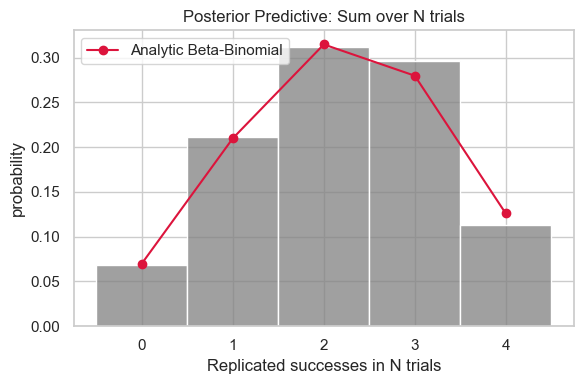

In [7]:
# PPC: per-trial replicated outcomes and Beta-Binomial predictive for future counts

def beta_binomial_pmf(k, n, a, b):
    # Beta-Binomial pmf without SciPy: C(n,k) * B(k+a, n-k+b) / B(a,b)
    from math import comb
    return comb(n, k) * (gamma(k + a) * gamma(n - k + b) / gamma(n + a + b)) * (gamma(a + b) / (gamma(a) * gamma(b)))

if y_rep is not None:
    # Distribution of sum of replicated trials across draws
    y_rep_sums = y_rep.sum(axis=1)

    plt.figure(figsize=(6,4))
    sns.histplot(y_rep_sums, bins=np.arange(-0.5, N + 1.5, 1), stat="probability", color="gray", edgecolor="white")
    plt.xticks(range(0, N+1))
    plt.xlabel("Replicated successes in N trials")
    plt.ylabel("probability")
    plt.title("Posterior Predictive: Sum over N trials")

    # Analytic Beta-Binomial overlay
    ks = np.arange(0, N+1)
    pmf = np.array([beta_binomial_pmf(int(k), int(N), alpha_post, beta_post) for k in ks])
    plt.plot(ks, pmf, marker="o", color="crimson", label="Analytic Beta-Binomial")
    plt.legend()
    plt.tight_layout()
    plt.show()



## MAP
1. Mode of the posterior if the posterior is $p(\theta|Y) = beta(\theta|\alpha,\beta)$
    $$
        \hat\theta_{MAP} = \frac{\alpha - 1}{\alpha-1 + \beta -1}
    $$

2. Numerical optimization can be used to get approximate estimate:

    `model.optimize(data=data)`


* Since we know the closed-form posterior distribution as a beta distribution, we can compute the two estimates. They should be the same within a numerical accuracy.

In [8]:
# Compute posterior Beta mode (MAP)

def beta_mode(alpha: float, beta: float) -> float:
    """Return the mode of Beta(alpha, beta).
    - If alpha>1 and beta>1: (alpha-1)/(alpha+beta-2)
    - If alpha<=1 and beta>1: mode at 0
    - If alpha>1 and beta<=1: mode at 1
    - If alpha<=1 and beta<=1: modes at boundaries (return NaN)
    """
    if alpha > 1 and beta > 1:
        return (alpha - 1) / (alpha + beta - 2)
    if alpha <= 1 and beta > 1:
        return 0.0
    if alpha > 1 and beta <= 1:
        return 1.0
    return float('nan')

post_mode = beta_mode(alpha_post, beta_post)
print({
    "posterior_alpha": alpha_post,
    "posterior_beta": beta_post,
    "posterior_mode": post_mode,
})

{'posterior_alpha': 6, 'posterior_beta': 5, 'posterior_mode': 0.5555555555555556}


In [9]:
result = model.optimize(data=data)
print("theta_hat_MAP:", result.optimized_params_dict.get("theta", None))

00:06:08 - cmdstanpy - INFO - Chain [1] start processing
00:06:08 - cmdstanpy - INFO - Chain [1] done processing
00:06:08 - cmdstanpy - INFO - Chain [1] done processing


theta_hat_MAP: 0.55555555


In [ ]:
# Optimize to obtain point estimate (MAP) using CmdStan
import importlib
has_cmdstanpy = importlib.util.find_spec("cmdstanpy") is not None
print("cmdstanpy available:", has_cmdstanpy)

if has_cmdstanpy:
    try:
        from cmdstanpy import CmdStanModel
        # Reuse existing compiled model if present; otherwise build it
        if 'model' not in globals() or model is None:
            model = CmdStanModel(stan_file=str(stan_path))

        # Ensure data exists
        if 'data' not in globals() or data is None:
            data = {
                "N": int(N),
                "y": Y.astype(int).tolist(),
                "alpha0": float(alpha0),
                "beta0": float(beta0),
            }

        map_est = model.optimize(data=data, seed=123)
        # print(map_est)

        # Extract parameter estimate(s)
        theta_hat = None
        if hasattr(map_est, 'optimized_params_dict'):
            theta_hat = map_est.optimized_params_dict.get('theta', None)
        print({
            "theta_hat": theta_hat,
            "analytic_MAP": ((alpha_post - 1) / (alpha_post + beta_post - 2)) \
                                if alpha_post > 1 and beta_post > 1 else float('nan'),
        })
    except Exception as e:
        print("Optimization failed (toolchain or model issue):")
        print(e)
else:
    print("cmdstanpy not installed; cannot run optimizer. Use the analytic MAP above.")

00:06:08 - cmdstanpy - INFO - Chain [1] start processing
00:06:08 - cmdstanpy - INFO - Chain [1] done processing


cmdstanpy available: True
{'theta_hat': 0.55555468, 'analytic_MAP': 0.5555555555555556}


End.